<a href="https://colab.research.google.com/github/efaro2014/2020-msds691-example/blob/master/Efrem_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [7]:
from google.colab import auth
auth.authenticate_user()
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'Efrem'
!gcloud config set project {project_id}

ERROR: (gcloud.config.set) The project property must be set to a valid project ID, not the project name [Efrem]
To set your project, run:

  $ gcloud config set project PROJECT_ID

or to unset it, run:

  $ gcloud config unset project


In [12]:
!gsutil cp gs://virgosvs-ml-train/upper-vs-lower/clips/*.mp4 /tmp

Copying gs://virgosvs-ml-train/upper-vs-lower/clips/110777.mp4...
Copying gs://virgosvs-ml-train/upper-vs-lower/clips/112066.mp4...
Copying gs://virgosvs-ml-train/upper-vs-lower/clips/112072.mp4...
Copying gs://virgosvs-ml-train/upper-vs-lower/clips/112078.mp4...
- [4 files][  1.0 GiB/  1.0 GiB]   85.3 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://virgosvs-ml-train/upper-vs-lower/clips/112082.mp4...
Copying gs://virgosvs-ml-train/upper-vs-lower/clips/120286.mp4...
Copying gs://virgosvs-ml-train/upper-vs-lower/clips/120287.mp4...
Copying gs://virgosvs-ml-train/upper-vs-lower/clips/120317.mp4...
Copying gs://virgosvs-ml-train/upper-vs-lower/clips/120318.mp4...
Copying gs://virgosvs-ml-train/upper-vs-lower/clips/164314.mp4...
Copying

In [13]:
import re

import numpy as np
import cv2
import h5py

from keras.utils import Sequence
import tensorflow as tf 
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [14]:
# Functions
def get_sample_frame(video_path, frame_pos=None):
    video = cv2.VideoCapture(video_path)
    if frame_pos is None:
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_pos = np.random.choice(total_frames)
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
    ret, frame = video.read()
    return frame  

def get_total_frame(video_path):
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    return total_frames

In [15]:
GREY_THRESH = 5
PAD_COLOR = [0, 0, 0]
def _nongrey_pixel_mask(frame, grey_threshold=GREY_THRESH):
    greyscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    color_diff = cv2.absdiff(frame, cv2.cvtColor(greyscale, cv2.COLOR_GRAY2BGR))
    color_diff_grey = cv2.cvtColor(color_diff, cv2.COLOR_BGR2GRAY)
    _, non_grey_pixels = cv2.threshold(color_diff_grey, grey_threshold, 255, cv2.THRESH_BINARY)
    return non_grey_pixels


def _get_bounding_box(frame, grey_threshold=GREY_THRESH):
    nongrey_pixels = _nongrey_pixel_mask(frame, grey_threshold)
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(5, 5))
    tmp = cv2.cvtColor(nongrey_pixels, cv2.COLOR_GRAY2BGR)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_OPEN, kernel, iterations=3)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
    return cv2.boundingRect(tmp)


def get_median_bounding_box(path, n_samples=20, grey_threshold=GREY_THRESH):
    video = cv2.VideoCapture(path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    sample_frames = np.linspace(0, total_frames - 1, num=n_samples).astype(int)

    bbs = []
    for frame_idx in sample_frames:
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = video.read()
        bb = _get_bounding_box(frame, grey_threshold=grey_threshold)
        bbs.append(bb)

    return np.median(bbs, axis=0)


class FramePreprocessor:
    def __init__(self, target_w: int, target_h: int):
        self.target_w = target_w
        self.target_h = target_h
        self.target_ratio = target_w/float(target_h)

    def simple_crop(self, frame, bounding_box):
        # crop:
        left, right = int(bounding_box[0]), int(bounding_box[0] + bounding_box[2])
        top, bottom = int(bounding_box[1]), int(bounding_box[1] + bounding_box[3])
        cropped_frame = frame[top:bottom, left:right]
        # resize:
        input_w, input_h = bounding_box[2], bounding_box[3]
        input_ratio = input_w / float(input_h)
        if input_ratio > self.target_ratio:
            resized_w = self.target_w
            resized_h = int(self.target_w/input_ratio)
        else:
            resized_h = self.target_h
            resized_w = int(self.target_h*input_ratio)
        resized = cv2.resize(cropped_frame, (resized_w, resized_h))
        # pad:
        delta_w, delta_h = self.target_w - resized_w, self.target_h - resized_h
        top_pad, bottom_pad = delta_h // 2, delta_h - (delta_h // 2)
        left_pad, right_pad = delta_w // 2, delta_w - (delta_w // 2)
        padded = cv2.copyMakeBorder(resized, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT,
                                    value=PAD_COLOR)
        return padded

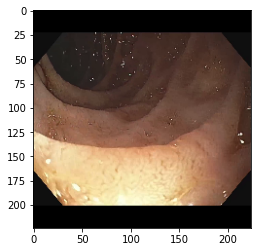

In [16]:
# get cropped frame
clip_id = '164329'
clip_path = f'/tmp/{clip_id}.mp4'
# get sample frame
frame = get_sample_frame(clip_path)
bounding_box = get_median_bounding_box(clip_path)
preprocessor = FramePreprocessor(224, 224) # change it to the same dim as resnet 
cropped_frame = preprocessor.simple_crop(frame, bounding_box)
plt.imshow(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
frame = get_sample_frame(clip_path)
# frame

In [18]:
# Zero-center by mean pixel
pretrained_mean = [103.939, 116.779, 123.68]
x = cropped_frame.astype('float64')
x[:, :, 0] -= pretrained_mean[0]
x[:, :, 1] -= pretrained_mean[1]
x[:, :, 2] -= pretrained_mean[2]

In [19]:
from keras.utils import Sequence
import cv2
import numpy as np
pretrained_mean = [103.939, 116.779, 123.68]
class VideoSequence(Sequence):
    def __init__(self, video_path, batch_size, w=224, h=224):
        self.video_path = video_path
        self.batch_size = batch_size
        self.position = 0
        self.video = cv2.VideoCapture(video_path)
        self.total_frames = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
        if w is None:
            w = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.w = w
        if h is None:
            h = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.h = h
        self.bounding_box = get_median_bounding_box(video_path)
        self.fpp = FramePreprocessor(self.w, self.h)
    def __len__(self):
        return int(np.ceil(self.total_frames / float(self.batch_size)))
    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_stop = (idx + 1) * self.batch_size
        #handling for the last batch
        batch_size = min(batch_stop, self.total_frames) - batch_start
        # if we can't sequentially read, we need to seek.
        if batch_start != self.position:
            self.video.set(cv2.CAP_PROP_POS_FRAMES, batch_start)
            self.position = batch_start
         
        frame_batch = np.zeros(shape=(batch_size, self.h, self.w, 3), dtype=np.uint8)
        for i in range(0, batch_size):
            _, frame = self.video.read()
            frame = self.fpp.simple_crop(frame, self.bounding_box)
            frame = frame.astype('float64')
            for k in range(3):
                frame[:,:,k] -= pretrained_mean[k]
            frame_batch[i] = frame
            self.position += 1
        return frame_batch

In [20]:
# initiate Resnet50
model = ResNet50( weights='imagenet', pooling='avg', include_top = False) # avg pooling

94773248/94765736 [==============================] - 2s 0us/step


In [21]:
from sklearn.linear_model  import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [22]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [23]:
# clf = LogisticRegression(max_iter=5000)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# confusion_matrix(y_test, y_pred)

In [24]:
import os
def filelist(root):
    """Return a fully-qualified list of filenames under root directory; sort names alphabetically."""
    allfiles = []
    for path, subdirs, files in os.walk(root):
        for name in files:
          if name.endswith('.mp4'):
            allfiles.append(os.path.join(path, name))
          else:
            continue
    return sorted(allfiles)
  
file_names = filelist('/tmp')



In [25]:
len(file_names)

130

In [26]:
import h5py
import re

In [28]:
# ! mkdir '/tmp/features/'

In [32]:
files = filelist('/tmp') # list of video path , '/tmp/164316.mp4', '/tmp/164329.mp4'

def gen_feature_files(model, files, prefix='/tmp/features/', batch_size=32):
  '''
  save features (.hdf5 format) from ResNet50 into the specified file path
  parameters
  ---------------
  model: Resnet50 model instance
  prefix: file path prefix
  files: list of video path
  Example ->  ['/tmp/110777.mp4', '/tmp/164316.mp4'] 


  '''
  for video_path in files:
    clip_id = re.search("(\d+).mp4$", video_path).group(1)
    video = VideoSequence(video_path, batch_size)
    feature = model.predict(video, batch_size=batch_size)
    file_name = f'{prefix}{clip_id}.mp4.hdf5'
    with h5py.File(file_name, 'w') as hf:
        hf.create_dataset(file_name,  data=feature)
        print(f'Save {clip_id}.mp4 features to {file_name}')
  

In [ ]:
gen_feature_files(model, files)

In [ ]:
!gsutil cp /tmp/features/*.hdf5 gs://virgosvs-ml-train/upper-vs-lower/resnet50-features/padded/ 

CommandException: No URLs matched: /tmp/features/*.hdf5


In [31]:
! ls /tmp/features/

In [ ]:
! rm -rf ~/.gsutil
! rm -rf /root/.gsutil


In [ ]:
!gsutil cp /tmp/features/*.hdf5 gs://virgosvs-ml-train/upper-vs-lower/resnet50-features/padded/

Copying file:///tmp/features/110777.mp4.hdf5 [Content-Type=application/octet-stream]...
ResumableUploadAbortException: 403 efrem@virgosvs.com does not have storage.objects.create access to virgosvs-ml-train/upper-vs-lower/resnet50-features/padded/110777.mp4.hdf5.
